In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tqdm import tqdm

import pyroomacoustics as pra
import itertools
import sklearn.metrics as sk_metrics


from pathlib import Path

import shamans.utils.eval_utils as eval

In [120]:
metrics_angular_threshold = 15
n_sources = 4
thresholds_ang_spec = [0., 0.05, 0.1, 0.2, 0.5, 0.6, 0.8, 0.9, 1.0]

Used the data of experiment 3, but use threshold to find the number of sources.

In [121]:
# merge all the csv fo the experiments 1 for different runs
def merge_csvs_and_get_dataframe(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*.csv')]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
    combined_csv.to_csv(path_to_results / f"experiment_results_exp-{exp_id}_all_runs.csv", index=False, encoding='utf-8-sig')
    return combined_csv

def merge_pickles_and_get_dict(exp_id, path_to_results):
    all_filenames = [i for i in path_to_results.glob(f'*_exp-{exp_id}_run-*_with_ang_specs.pkl')]
    combined_dicts = []
    for filename in tqdm(all_filenames):
        with open(filename, 'rb') as f:
            combined_dicts += pickle.load(f)
    with open(path_to_results / f"experiment_results_exp-{exp_id}_all_runs_with_ang_specs.pkl", 'wb') as f:
        pickle.dump(combined_dicts, f)
    return combined_dicts

In [122]:
# load data
exp_id = 3
path_to_results = Path('results_2025-03-13/')
exp_df = merge_csvs_and_get_dataframe(exp_id, path_to_results)
ang_specs = merge_pickles_and_get_dict(exp_id, path_to_results)

100%|██████████| 10/10 [00:00<00:00, 13.83it/s]


In [123]:
exp_df.columns

Index(['exp_name', 'time', 'record_id', 'num_srcs', 'src_ids', 'doas_est_idx',
       'doas_ref_idx', 'doas_ref_az', 'doas_est_az', 'doas_ref_el',
       'doas_est_el', 'errors', 'speech_files', 'frame_id', 'target_doa',
       'n_sources', 'duration', 'snr', 'noise_type', 'rt60', 'mc_seed',
       'method_id', 'loc_method', 'freq_min', 'freq_max', 'sv_method', 'nObs',
       'seed', 'sv_normalization'],
      dtype='object')

In [124]:
print(exp_df['seed'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())

[ 13 666]
['awgn']
[1 2 3 4 5 6 7]
[20]
[1.]
[0.    0.123 0.273]
['alpha-2.0_beta-2_eps-1E-3_iter-500' 'music_s-4'
 'alpha-1.2_beta-0_eps-1E-3_iter-500' 'music_s-2' 'music_s-6' 'music_s-3'
 'alpha-1.2_beta-2_eps-1E-3_iter-500' 'alpha-1.2_beta-1_eps-1E-3_iter-500'
 'srp_phat' 'music_s-1' 'music_s-5']


In [125]:
exp_df['loc_method_simple'] = exp_df['loc_method'].apply(lambda x: x.split('-')[0])

best_seed = 666
# rename ref_8 and alg_6 to ref and alg
exp_df = exp_df.assign(sv_model=exp_df['sv_method'] + '_' + exp_df['nObs'].astype(str))
exp_df = exp_df.assign(loc_algo=exp_df['loc_method'].str[:3])
exp_df['sv_model'] = exp_df['sv_model'].str.replace('ref_8', 'ref')
exp_df['sv_model'] = exp_df['sv_model'].str.replace('alg_8', 'alg')
exp_df.loc[exp_df['sv_model'] == 'ref', 'seed'] = 666
exp_df.loc[exp_df['sv_model'] == 'alg', 'seed'] = 666

exp_df = exp_df[
    (exp_df['n_sources'] == n_sources)
    & (exp_df['loc_method'].isin([
        'srp_phat', 
        'music_s-1', 
        'music_s-4', 
        'music_s-6', 
        'alpha-1.2_beta-1_eps-1E-3_iter-500',
        ]))
    & (exp_df['duration'] == 1)
    & (exp_df['rt60'] == 0.123)
]
print(len(exp_df))

# laod picke file with the ground truth
with open(path_to_results / 'experiment_results_exp-3_all_runs_with_ang_specs.pkl', 'rb') as f:
    list_of_ang_specs = pickle.load(f)
    
print(exp_df.shape)
print(len(list_of_ang_specs))

doa_grid_rad = np.deg2rad(np.arange(0, 360, 6))

1400
(1400, 32)
16170


In [126]:
unique_frame_ids = exp_df['frame_id'].unique()
print(len(unique_frame_ids))
unique_method_ids = exp_df['method_id'].unique()
print(len(unique_method_ids))

10
35


In [127]:
print(exp_df['seed'].unique())
print(exp_df['noise_type'].unique())
print(exp_df['n_sources'].unique())
print(exp_df['snr'].unique())
print(exp_df['duration'].unique())
print(exp_df['rt60'].unique())
print(exp_df['loc_method'].unique())

[666]
['awgn']
[4]
[20]
[1.]
[0.123]
['music_s-4' 'music_s-6' 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'srp_phat'
 'music_s-1']


In [128]:
# initialize the dict with the frame ids
ang_specs_dicts = {}
for frame_id in unique_frame_ids:
    ang_specs_dicts[frame_id] = {}
    for method_id in unique_method_ids:
        ang_specs_dicts[frame_id][method_id] = None

for d in tqdm(list_of_ang_specs):
    if not d['frame_id'] in unique_frame_ids:
        continue
    if not d['method_id'] in unique_method_ids:
        continue
    # add the method id to the frame id
    ang_specs_dicts[d['frame_id']][d['method_id']] = d
    
# check if all the frames are there
missing_frames = []
retrieve_frames = []
for frame_id in unique_frame_ids:
    for method_id in unique_method_ids:
        if ang_specs_dicts[frame_id][method_id] is None:
            missing_frames.append((frame_id))
        else:
            retrieve_frames.append((frame_id))
            
print("Missing:", len(np.unique(missing_frames)))
print(np.unique(missing_frames))
print("Retrieved:", len(np.unique(retrieve_frames)))
print(np.unique(retrieve_frames))

100%|██████████| 16170/16170 [00:00<00:00, 372443.14it/s]

Missing: 0
[]
Retrieved: 10
['nSrc-4_doas-[ 3 20 59 51]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-8'
 'nSrc-4_doas-[10 45 20 52]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-6'
 'nSrc-4_doas-[38 22  1 50]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-9'
 'nSrc-4_doas-[45 14 57 48]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-5'
 'nSrc-4_doas-[47 53 12  8]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-1'
 'nSrc-4_doas-[50 15 55  8]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-2'
 'nSrc-4_doas-[52 24  3  8]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-3'
 'nSrc-4_doas-[54 57  0  3]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-0'
 'nSrc-4_doas-[56  5  1 50]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-4'
 'nSrc-4_doas-[57  4 35 19]_type-speech-duration-1.0-snr-20_noise-awgn_reverb-0.123_mc-7']


In [129]:
assert len(ang_specs_dicts.keys()) == len(unique_frame_ids), f"{len(ang_specs_dicts.keys())} != {len(unique_frame_ids)}"

In [130]:
def detect_peaks(values):
    # make circular
    n_points = len(values)
    val_ext = np.append(values, values[:10])

    # run peak finding
    indexes = pra.doa.detect_peaks(val_ext, show=False) % n_points
    candidates = np.unique(indexes)  # get rid of duplicates, if any
    return candidates

In [131]:
df_results = pd.DataFrame()

for thr in thresholds_ang_spec:
    
    for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames for thr={}'.format(thr)):
        
        for method_id in unique_method_ids:
            
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            assert len(ang_spec.shape) == 2
            assert ang_spec.shape[0] == len(doa_grid_rad)
            ang_spec = np.mean(np.array(ang_spec), -1)
            ang_spec = ang_spec / np.max(ang_spec)
            
            # set the threshold
            ang_spec[ang_spec < thr] = 0
            
            # find peaks
            peaks = detect_peaks(ang_spec)     
            
            df_ = pd.DataFrame({
                'frame_id': frame_id,
                "method_id": method_id,
                'thresholds_ang_spec': thr,
                'peaks_locations': peaks.tolist(),
                'peaks_ids' : [f'p{i}' for i in range(len(peaks))],
                'n_peaks': len(peaks)
            })
            df_results = pd.concat([df_results, df_], ignore_index=True)
        
print(len(df_results))

Iterating over frames for thr=1.0: 100%|██████████| 10/10 [00:00<00:00, 59.71it/s]

14190


In [132]:
# merge the results_df with the exp_df on the frame_id and method_id
df_merge = exp_df.merge(df_results, on=['frame_id', 'method_id'])
print(len(df_merge))

56760


In [133]:
print(df_merge['seed'].unique())
print(df_merge['noise_type'].unique())
print(df_merge['n_sources'].unique())
print(df_merge['snr'].unique())
print(df_merge['duration'].unique())
print(df_merge['rt60'].unique())
print(df_merge['loc_method'].unique())

[666]
['awgn']
[4]
[20]
[1.]
[0.123]
['music_s-4' 'music_s-6' 'alpha-1.2_beta-1_eps-1E-3_iter-500' 'srp_phat'
 'music_s-1']


In [134]:
results_thr_list = []

for frame_id in tqdm(unique_frame_ids, desc='Iterating over frames'):
    for method_id in unique_method_ids:
        
        df_ = df_merge.loc[
            (df_merge['frame_id'] == frame_id) 
            & (df_merge['method_id'] == method_id)
        ]
        
        thrs = df_['thresholds_ang_spec'].unique()
        
        for thr in thrs:
            
            n_sources = df_.loc[df_['thresholds_ang_spec'] == thr, 'n_sources'].unique()
            
            assert len(n_sources) == 1
            n_sources = n_sources[0]
            
            estimated_peaks_loc = df_.loc[df_['thresholds_ang_spec'] == thr, 'peaks_locations'].unique()
            estimated_azimuths = np.rad2deg(doa_grid_rad[estimated_peaks_loc])
            target_azimuths = np.rad2deg(df_.loc[df_['thresholds_ang_spec'] == thr, 'doas_ref_az'].unique())
            
            n_estimated = len(estimated_azimuths)
            n_target = len(target_azimuths)
            assert n_target == n_sources, f"{n_target} != {n_sources} \n {frame_id}"
            
            metrics = eval.compute_metrics(estimated_azimuths, target_azimuths, metrics_angular_threshold, np.rad2deg(doa_grid_rad))
            
            # print(metrics['TP'], metrics['FP'], metrics['FN'], metrics['TN'])
            
            # check that tpr and fpr are not nans
            if np.isnan(metrics['tpr']) or np.isnan(metrics['fpr']):
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('TPR or FPR is nan')
            
            
            if len(target_azimuths) > n_sources:
                print(frame_id)
                print(estimated_azimuths)
                print(target_azimuths)
                print(n_sources)
                print(method_id)
                print(df_.loc[df_['thresholds_ang_spec'] == thr])
                raise ValueError('True positives greater than n_sources')
            
            metrics['frame_id'] = frame_id
            metrics['method_id'] = method_id
            metrics['metrics_angular_threshold'] = metrics_angular_threshold
            metrics['thresholds_ang_spec'] = float(thr)
            
            results_thr_list.append(metrics)
        
df_results_thr_ = pd.DataFrame(results_thr_list)

Iterating over frames: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [135]:
df_results_thr = df_results_thr_.merge(df_merge, on=['frame_id', 'method_id', 'thresholds_ang_spec'])
df_results_thr[:100].to_csv('asd.csv', index=False)
len(df_results_thr)

print(len(df_merge['method_id'].unique()))
print(len(df_results_thr_['method_id'].unique()))
print(len(df_results_thr['method_id'].unique()))

35
35
35


In [136]:
thrs = np.sort(df_['thresholds_ang_spec'].unique())[::-1]
print(thrs)

auc_df = pd.DataFrame()

for rt60 in df_results_thr['rt60'].unique():

    # plt.figure(figsize=(8, 6))
    # plt.title(f'ROC curve for RT60={rt60}')
    
    for method_id in unique_method_ids:

        tpr_list = []
        fpr_list = []
        f1_list = []
        
        for t, thr in enumerate(thrs):
            
            df_ = df_results_thr.loc[
                    (df_results_thr['method_id'] == method_id)
                    & (df_results_thr['rt60'] == rt60)
                ]
            
            loc_method = df_['loc_method'].unique()
            sv_method = df_['sv_method'].unique()
            assert len(sv_method) == 1
            sv_method = sv_method[0]
            assert len(loc_method) == 1
            loc_method = loc_method[0]
            nObs = df_['nObs'].unique()
            assert len(nObs) == 1
            nObs = nObs[0]
                                    
            # micro-averaging over the frames
            TP = FP = FN = TN = 0.0
            tpr_list_ = []
            fpr_list_ = []
                        
            for frame_id in df_['frame_id'].unique():
                
                df__ = df_[(df_['frame_id'] == frame_id)]
                    
                TPs = df__[df__['thresholds_ang_spec'] == thr]['TP'].unique()
                FPs = df__[df__['thresholds_ang_spec'] == thr]['FP'].unique()
                FNs = df__[df__['thresholds_ang_spec'] == thr]['FN'].unique()
                TNs = df__[df__['thresholds_ang_spec'] == thr]['TN'].unique()
                peaks_id = df__[df__['thresholds_ang_spec'] == thr]['peaks_ids'].values
                
                tpr = df__[df__['thresholds_ang_spec'] == thr]['tpr'].unique()
                fpr = df__[df__['thresholds_ang_spec'] == thr]['fpr'].unique()
                
                # check that tpr and fpr are not nans
                if np.isnan(TPs) or np.isnan(FPs) or np.isnan(FNs) or np.isnan(TNs):
                    print(frame_id)
                    print(peaks_id)
                    print(TPs, FPs, FNs, TNs)
                    print(method_id)
                    print(df__)
                    raise ValueError('TPR or FPR is nan')
                
                assert len(np.unique(TPs)) == len(np.unique(FPs)) == len(np.unique(FNs)) == len(np.unique(TNs)) == 1
                assert len(np.unique(tpr)) == len(np.unique(fpr)) == 1
                
                TP += TPs[0]
                FP += FPs[0]
                FN += FNs[0]
                TN += TNs[0]
                                            
                tpr_list_.append(tpr[0])
                fpr_list_.append(fpr[0])
                
            
            # import ipdb; ipdb.set_trace()
            tpr = TP / (TP + FN)
            fpr = FP / (FP + TN)
            f1 = 2 * TP / (2 * TP + FP + FN)
            
            tpr_list.append(np.mean(tpr_list_))
            fpr_list.append(np.mean(fpr_list_))
            f1_list.append(f1)
            
        # plot ROC curve
        
        tpr_list = [0] + tpr_list + [1]
        fpr_list = [0] + fpr_list + [1]
        
        label = method_id
        
        # compute AUC
        auc = np.trapezoid(tpr_list, fpr_list)
        auc_sk = sk_metrics.auc(fpr_list, tpr_list)
        
        auc_df_ = pd.DataFrame({
            'loc_method': loc_method,
            'sv_method': sv_method,
            'nObs': nObs,
            'method_id': method_id,
            'auc': auc,
            'auc_sk': auc_sk,
            'rt60': rt60,
            'f1' : np.max(f1_list),
            'ang_spec_thr': metrics_angular_threshold
        }, index=[0])
        auc_df = pd.concat([auc_df, auc_df_], ignore_index=True)
        
        print(f'AUC for {label} is {auc:0.3f}')
        
        label = loc_method + ' ' + sv_method + ' ' + str(nObs)
        # if 'alpha' in loc_method:
        #     plt.step(fpr_list, tpr_list, label=label, linestyle='--', where='pre')
        # else:
        #     plt.step(fpr_list, tpr_list, label=label, where='pre')

        
    # plt.legend(loc='lower right')
    # plt.show()

[1.   0.9  0.8  0.6  0.5  0.2  0.1  0.05 0.  ]
AUC for music_s-4_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True is 0.977
AUC for music_s-4_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True is 0.656
AUC for music_s-4_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True is 0.870
AUC for music_s-4_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True is 0.789
AUC for music_s-4_freqs-[200, 4000]_gp-steerer_nObs-32_seed-666_norm-True is 0.828
AUC for music_s-4_freqs-[200, 4000]_gp-steerer_nObs-64_seed-666_norm-True is 0.947
AUC for music_s-4_freqs-[200, 4000]_gp-steerer_nObs-128_seed-666_norm-True is 0.957
AUC for music_s-6_freqs-[200, 4000]_ref_nObs-8_seed-13_norm-True is 0.863
AUC for music_s-6_freqs-[200, 4000]_alg_nObs-8_seed-13_norm-True is 0.840
AUC for music_s-6_freqs-[200, 4000]_gp-steerer_nObs-8_seed-666_norm-True is 0.871
AUC for music_s-6_freqs-[200, 4000]_gp-steerer_nObs-16_seed-666_norm-True is 0.866
AUC for music_s-6_freqs-[200, 4000]_gp-steerer_nObs-32_seed-666_norm-True is 

In [137]:
nice_plot_df = auc_df.copy()
nice_plot_df = nice_plot_df.assign(sv_model=nice_plot_df['sv_method'] + '_' + nice_plot_df['nObs'].astype(str))
nice_plot_df = nice_plot_df.assign(loc_algo=nice_plot_df['loc_method'].str[:3])

nice_plot_df

,loc_method,sv_method,nObs,method_id,auc,auc_sk,rt60,f1,ang_spec_thr,sv_model,loc_algo
0,music_s-4,ref,8,"music_s-4_freqs-[200, 4000]_ref_nObs-8_seed-13...",0.976944,0.976944,0.123,0.808511,15,ref_8,mus
1,music_s-4,alg,8,"music_s-4_freqs-[200, 4000]_alg_nObs-8_seed-13...",0.656069,0.656069,0.123,0.415094,15,alg_8,mus
2,music_s-4,gp-steerer,8,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-8_...",0.869873,0.869873,0.123,0.527273,15,gp-steerer_8,mus
3,music_s-4,gp-steerer,16,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-16...",0.789069,0.789069,0.123,0.432990,15,gp-steerer_16,mus
4,music_s-4,gp-steerer,32,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-32...",0.828152,0.828152,0.123,0.525000,15,gp-steerer_32,mus
5,music_s-4,gp-steerer,64,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-64...",0.946660,0.946660,0.123,0.711111,15,gp-steerer_64,mus
6,music_s-4,gp-steerer,128,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-12...",0.957364,0.957364,0.123,0.750000,15,gp-steerer_128,mus
7,music_s-6,ref,8,"music_s-6_freqs-[200, 4000]_ref_nObs-8_seed-13...",0.862738,0.862738,0.123,0.341463,15,ref_8,mus
8,music_s-6,alg,8,"music_s-6_freqs-[200, 4000]_alg_nObs-8_seed-13...",0.839564,0.839564,0.123,0.357724,15,alg_8,mus
9,music_s-6,gp-steerer,8,"music_s-6_freqs-[200, 4000]_gp-steerer_nObs-8_...",0.870506,0.870506,0.123,0.397790,15,gp-steerer_8,mus


In [138]:
nice_plot_df['sv_model'] = nice_plot_df['sv_model'].str.replace('ref_8', 'ref')
nice_plot_df['sv_model'] = nice_plot_df['sv_model'].str.replace('alg_8', 'alg')
nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'seed'] = 666
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'seed'] = 666

nice_plot_df.loc[nice_plot_df['loc_method'] == 'srp_phat', 'loc_method'] = 'SRP-PHAT'
for nSrc in [1, 2, 4, 5, 6]:
    nice_plot_df.loc[nice_plot_df['loc_method'] == f'music_s-{nSrc}', 'loc_method'] = f'MUSIC-{nSrc}'
nice_plot_df.loc[nice_plot_df['loc_method'] == 'alpha-1.2_beta-1_eps-1E-3_iter-500', 'loc_method'] = 'SHAMaNS'

nice_plot_df.loc[nice_plot_df['sv_model'] == 'ref', 'sv_model'] = 'Ref.'
nice_plot_df.loc[nice_plot_df['sv_model'] == 'alg', 'sv_model'] = 'Alg.'
for nObs in [8, 16, 32, 64, 128]:
    nice_plot_df.loc[nice_plot_df['sv_model'] == f'gp-steerer_{nObs}', 'sv_model'] = f'NS-{nObs}'

algo_order = ['SRP-PHAT', 'MUSIC-1', 'MUSIC-4', 'SHAMaNS']
n_algos = len(algo_order)
print(nice_plot_df['sv_model'].unique())
print(nice_plot_df['loc_method'].unique())

['Ref.' 'Alg.' 'NS-8' 'NS-16' 'NS-32' 'NS-64' 'NS-128']
['MUSIC-4' 'MUSIC-6' 'SHAMaNS' 'SRP-PHAT' 'MUSIC-1']


In [139]:
nice_plot_df

,loc_method,sv_method,nObs,method_id,auc,auc_sk,rt60,f1,ang_spec_thr,sv_model,loc_algo,seed
0,MUSIC-4,ref,8,"music_s-4_freqs-[200, 4000]_ref_nObs-8_seed-13...",0.976944,0.976944,0.123,0.808511,15,Ref.,mus,666.0
1,MUSIC-4,alg,8,"music_s-4_freqs-[200, 4000]_alg_nObs-8_seed-13...",0.656069,0.656069,0.123,0.415094,15,Alg.,mus,666.0
2,MUSIC-4,gp-steerer,8,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-8_...",0.869873,0.869873,0.123,0.527273,15,NS-8,mus,NaN
3,MUSIC-4,gp-steerer,16,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-16...",0.789069,0.789069,0.123,0.432990,15,NS-16,mus,NaN
4,MUSIC-4,gp-steerer,32,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-32...",0.828152,0.828152,0.123,0.525000,15,NS-32,mus,NaN
5,MUSIC-4,gp-steerer,64,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-64...",0.946660,0.946660,0.123,0.711111,15,NS-64,mus,NaN
6,MUSIC-4,gp-steerer,128,"music_s-4_freqs-[200, 4000]_gp-steerer_nObs-12...",0.957364,0.957364,0.123,0.750000,15,NS-128,mus,NaN
7,MUSIC-6,ref,8,"music_s-6_freqs-[200, 4000]_ref_nObs-8_seed-13...",0.862738,0.862738,0.123,0.341463,15,Ref.,mus,666.0
8,MUSIC-6,alg,8,"music_s-6_freqs-[200, 4000]_alg_nObs-8_seed-13...",0.839564,0.839564,0.123,0.357724,15,Alg.,mus,666.0
9,MUSIC-6,gp-steerer,8,"music_s-6_freqs-[200, 4000]_gp-steerer_nObs-8_...",0.870506,0.870506,0.123,0.397790,15,NS-8,mus,NaN


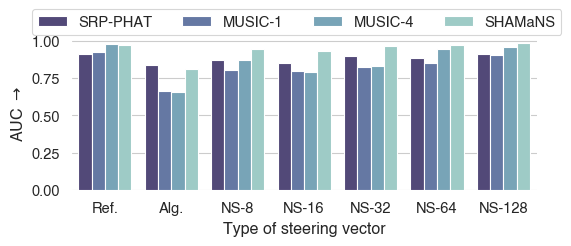

In [166]:
sns.set(style='whitegrid', context='paper', font_scale=1.2,
        rc={
            'figure.figsize':(3.5,3.15), 
            'lines.linewidth':2.,
            'font.family': 'sans-serif',
            'font.sans-serif': [u'Helvetica'],
            'text.usetex': False,
            })
pal = sns.cubehelix_palette(n_algos, start=0.5, rot=-0.5,dark=0.3, light=.75, reverse=True, hue=1.)
sns.set_palette(pal)


fig = plt.figure(figsize=(6, 2.))
ax = plt.gca()
ax = sns.barplot(
    data=nice_plot_df, 
    hue='loc_method', 
    y='auc', 
    x='sv_model', 
    hue_order=algo_order, ax=ax,
    )
ax.set_xlabel('Type of steering vector')
ax.set_ylabel('AUC ' + r"$\rightarrow$")
# place the legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
ax.legend().set_visible(False)

sns.despine(offset=10, trim=False, left=True, bottom=True, ax=ax)

plt.savefig(f'./eusipco2025_exp-{exp_id}_auc.pdf', bbox_inches='tight')
# plt.suptitle(f'AUC for different methods\n n_sources = {n_sources}', y=1.05)
plt.show()

# Plot angular spectrograms

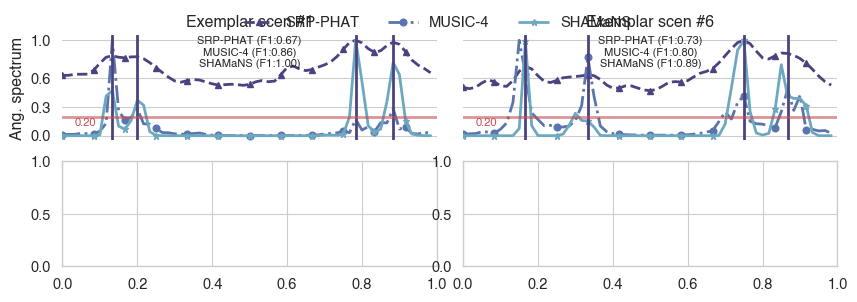

In [ ]:
markers=['^','o','*','s','d','v']

fig, axarr = plt.subplots(2, 2, figsize=(10, 3), gridspec_kw = {'wspace':0.07})

for i, thr in enumerate([0.2, 0.5]):
    
    for j, idx in enumerate([4, -1]):
    
        ax = axarr[i, j]
        
        frame_id = df_results_thr['frame_id'].unique()[idx]

        curr_df = df_results_thr[
            (df_results_thr['frame_id'] == frame_id)
        ]

        curr_df['method_id'].unique()
        curr_df['sv_model'].unique()

        true_azimuths = curr_df['doas_ref_idx'].unique()

        method_ids = curr_df['method_id'].unique()
        
        # reorder method_ids to have steering that start with SRP-PHAT, MUSIC-4, SHAMaNS
        method_ids = sorted(method_ids, key=lambda x: x.split('_')[0])[::-1]

        F1_text = []

        for m, method_id in enumerate(method_ids):
            
            if not 'ref' in method_id:
                continue
            if "music_s-6" in method_id:
                continue
            if "music_s-1" in method_id:
                continue
            
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            ang_spec = ang_spec.mean(-1)
            ang_spec /= np.max(ang_spec) 
            
            df_ = curr_df.loc[
                (curr_df['method_id'] == method_id) 
                & (curr_df['thresholds_ang_spec'] == thr), 
            ]
            
            # retrieve the predicted azimuths
            estimated_peaks_loc = df_['peaks_locations'].unique()
            tp = df_['TP'].unique()
            fp = df_['FP'].unique()
            fn = df_['FN'].unique()
            tn = df_['TN'].unique()
            # compute f1
            f1 = 2 * tp / (2 * tp + fp + fn)

            label = '_'.join(method_id.split('_')[:2])
            
            if 'srp' in method_id:
                label = 'SRP-PHAT'
                ax.plot(ang_spec, '--', label=label, marker=markers[0], markevery=5)
            elif 'music' in method_id:
                label = 'MUSIC-4'
                ax.plot(ang_spec, '-.', label=label, marker=markers[1], markevery=5)
            else:
                label = 'SHAMaNS'
                ax.plot(ang_spec, '-', label=label, marker=markers[2], markevery=5)
                
            F1_text.append(f"{label} (F1:{f1[0]:.2f})")
                
        for az in true_azimuths:
            ax.axvline(x=az)
        
        # # add a little text indicating the F1 score for each method
        F1_text = '\n'.join(F1_text)
        ax.text(0.5, 0.7, F1_text, transform=ax.transAxes, fontsize=8, ha='center')
        
        
        ax.axhline(thr, color='r', alpha=0.6)
        # add a small text above the threshold line to report the value
        ax.text(2, thr-0.1, f'{thr:.2f}', color='r', fontsize=8)
        
        ax.set_xlim([0, 60])
        
        # if i == 0:
        #     ax.set_title(f'Frame {frame_id} with threshold {thr}')
        if j == 0:
            ax.set_ylabel(f'Ang. spectrum')
        else:
            ax.set_yticklabels([])
        
        if i == 0:
            ax.set_title(f'Exemplar scen #{frame_id[-1]}')
            ax.set_xticklabels([])
        elif i == 1:
            ax.set_xlabel('Azimuth [Degree]')
            # convert the ticks to degrees (just multiply by 6)
            xticks = ax.get_xticks()
            ax.set_xticklabels([f'{int(x*6)}' for x in xticks])
        else:
            ax.set_xticklabels([])
        
        ax.set_yticks([0, 0.3, 0.6, 1])
        ax.xaxis.grid(False)

        
        sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])


# add a common legend about the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.99), frameon=False)
plt.savefig(f'./eusipco2025_exp-{exp_id}_ang_specs.pdf', bbox_inches='tight')
plt.show()


/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_9141/2495283415.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x*6)}' for x in xticks])
/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_9141/2495283415.py:100: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x*6)}' for x in xticks])


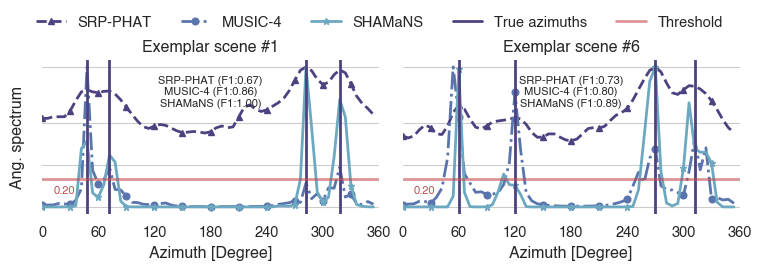

In [165]:
# markers=['^','o','*','s','d','v']

fig, axarr = plt.subplots(1, 2, figsize=(9, 2), gridspec_kw = {'wspace':0.07}, squeeze=False, sharey=True)

for i, thr in enumerate([0.2]):
    
    for j, idx in enumerate([4, -1]):
    
        ax = axarr[i, j]
        
        frame_id = df_results_thr['frame_id'].unique()[idx]

        curr_df = df_results_thr[
            (df_results_thr['frame_id'] == frame_id)
        ]

        curr_df['method_id'].unique()
        curr_df['sv_model'].unique()

        true_azimuths = curr_df['doas_ref_idx'].unique()

        method_ids = curr_df['method_id'].unique()
        
        # reorder method_ids to have steering that start with SRP-PHAT, MUSIC-4, SHAMaNS
        method_ids = sorted(method_ids, key=lambda x: x.split('_')[0])[::-1]

        F1_text = []

        for m, method_id in enumerate(method_ids):
            
            if not 'ref' in method_id:
                continue
            if "music_s-6" in method_id:
                continue
            if "music_s-1" in method_id:
                continue
            
            ang_spec = ang_specs_dicts[frame_id][method_id]['ang_spec']
            ang_spec = ang_spec.mean(-1)
            ang_spec /= np.max(ang_spec) 
            
            df_ = curr_df.loc[
                (curr_df['method_id'] == method_id) 
                & (curr_df['thresholds_ang_spec'] == thr), 
            ]
            
            # retrieve the predicted azimuths
            estimated_peaks_loc = df_['peaks_locations'].unique()
            tp = df_['TP'].unique()
            fp = df_['FP'].unique()
            fn = df_['FN'].unique()
            tn = df_['TN'].unique()
            # compute f1
            f1 = 2 * tp / (2 * tp + fp + fn)

            label = '_'.join(method_id.split('_')[:2])
            
            if 'srp' in method_id:
                label = 'SRP-PHAT'
                ax.plot(ang_spec, '--', label=label, marker=markers[0], markevery=5)
            elif 'music' in method_id:
                label = 'MUSIC-4'
                ax.plot(ang_spec, '-.', label=label, marker=markers[1], markevery=5)
            else:
                label = 'SHAMaNS'
                ax.plot(ang_spec, '-', label=label, marker=markers[2], markevery=5)
                
            F1_text.append(f"{label} (F1:{f1[0]:.2f})")
                
        for a, az in enumerate(true_azimuths):
            if a == 0:
                ax.axvline(x=az, label='True azimuths')
            else:
                ax.axvline(x=az)
            
        
        # # add a little text indicating the F1 score for each method
        F1_text = '\n'.join(F1_text)
        ax.text(0.5, 0.7, F1_text, transform=ax.transAxes, fontsize=8, ha='center')
        
        
        ax.axhline(thr, color='r', alpha=0.6, label='Threshold')
        # add a small text above the threshold line to report the value
        ax.text(2, thr-0.1, f'{thr:.2f}', color='r', fontsize=8)
        
        ax.set_xlim([0, 60])
        
        # if i == 0:
        #     ax.set_title(f'Frame {frame_id} with threshold {thr}')
        if j == 0:
            ax.set_ylabel(f'Ang. spectrum')
        else:
            ax.set_yticklabels([])
        
        if i == 0:
            ax.set_title(f'Exemplar scene #{frame_id[-1]}')
            ax.set_xlabel('Azimuth [Degree]')
            # convert the ticks to degrees (just multiply by 6)
            xticks = ax.get_xticks()
            ax.set_xticklabels([f'{int(x*6)}' for x in xticks])
        
        ax.set_yticks([0, 0.3, 0.6, 1])
        ax.xaxis.grid(False)

        
        sns.despine(offset=10, trim=False, left=True, bottom=True, ax=axarr[i,j])


# add a common legend about the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.17), frameon=False)
plt.savefig(f'./eusipco2025_exp-{exp_id}_ang_specs.pdf', bbox_inches='tight')
plt.show()
